## Analysis of reddit communities
* Downloaded https://files.pushshift.io/reddit/comments/ file from October 2018 (RC_2018-10) , File of comments on reddit
* There are  112 346 556  comments in the file
* Comments are a vital part of the reddit community, users commenting in a community is an important indicator of the users interest. These interactions can help the service provider to detect similar communities based on how users interact with  communities. 
* The objective of this analysis is to detect groups of subreddits that are implicitly related through how users comment.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import codecs

In [3]:
import numpy as np

In [4]:
import squarify

In [5]:
from datetime import datetime

In [6]:
from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool

In [7]:
import bokeh.models as bmo
from bokeh.palettes import d3

In [8]:
from bokeh.io import output_notebook

In [9]:
%matplotlib inline

In [10]:
output_notebook()

Loading BokehJS ...

In [11]:
plt.rcParams['figure.figsize']=(20,10)

In [4]:
df_comments_iter=pd.read_json(codecs.open('./data/RC_filtered.json','r','utf-8'), orient='records', lines=True, chunksize=1000000)

In [5]:
dict_authors={}

In [6]:
df_interactions=None

In [7]:
times=0
for df_temp in df_comments_iter:
    
    del df_temp['text']
    df_elems=df_temp[['author', 'author_created_utc', 'controversiality', 'created','subreddit']]
    if df_interactions is None:
        df_interactions=df_elems
    else:
        df_interactions=pd.concat([df_interactions,df_elems])
    df_temp=df_temp[~df_temp.author_created_utc.isna()]
    dict_df=pd.Series(df_temp.author_created_utc.values, index=df_temp.author)
    times+=1
    dict_authors.update(dict_df.to_dict())
    
   
    
    


In [8]:
df_interactions.shape

(112346556, 5)

In [9]:
dict_authors['Tack22']

1376831517.0

In [10]:
#df_interactions=pd.read_pickle('./data/interactions.pkl')
df_interactions.to_pickle('./data/interactions.pkl')


In [11]:
df_interactions.head()

,author,author_created_utc,controversiality,created,subreddit
0,TistedLogic,1.312616e+09,0,1538352000,Unexpected
1,misssaladfingers,1.536865e+09,0,1538352000,insomnia
2,Increase_Vitality,1.467817e+09,0,1538352000,pics
3,volkanize,1.531799e+09,0,1538352000,NoStupidQuestions
4,[deleted],NaN,0,1538352000,steroids


In [51]:
df_interactions.tail()

,author,controversiality,created,subreddit
112346551,DontBeAFlatlinerMan,0,1541030399,Bitcoin
112346552,HipsterBefore_You,0,1541030399,dogs
112346553,Emerald_Triangle,0,1541030399,gifs
112346554,scarecrowslayer,0,1541030399,soccer
112346555,ipan12,0,1541030399,indonesia


### Interactions come from October 2018

In [49]:
str(datetime.utcfromtimestamp(df_interactions.created.min()))

'2018-10-01 00:00:00'

In [48]:
str(datetime.utcfromtimestamp(df_interactions.created.max()))

'2018-10-31 23:59:59'

### Remove interactions that are in user's pages, not subreddits, they start with u_

In [31]:
df_interactions=df_interactions[~df_interactions.subreddit.str.startswith('u_')]

In [34]:
df_interactions.shape

(112183892, 5)

### At first glance, it makes sense that the subreddits that have most of the interactions are the ones that are oriented to conversation, being AskReddit the main example, however a closer exploration of the dataset is needed in order to see if all the comments should count in order to see how subreddits are related to one another

In [35]:
df_interactions.subreddit.value_counts().head(20)

AskReddit            5834042
politics             2208780
nfl                  1285725
The_Donald           1207555
funny                 999457
fantasyfootball       956079
nba                   902452
leagueoflegends       886118
CFB                   882986
worldnews             834164
FortNiteBR            799807
news                  758534
pics                  717980
AskOuija              714345
gaming                693736
Blackops4             606413
soccer                586826
baseball              578326
reddeadredemption     561949
dankmemes             560701
Name: subreddit, dtype: int64

In [36]:
df_interactions.subreddit.value_counts().describe()

count    9.021100e+04
mean     1.243572e+03
std      2.573212e+04
min      1.000000e+00
25%      2.000000e+00
50%      8.000000e+00
75%      6.000000e+01
max      5.834042e+06
Name: subreddit, dtype: float64

### Im going to explore how users participate in the communities, first I'm going to aggregate by author, so I can see how authors behave in the website

In [38]:
df_gp_author=df_interactions.groupby('author')

In [39]:
grouped_author=df_gp_author.agg({'author':'count','subreddit':set, 'author_created_utc': min, 'controversiality': np.mean })

In [45]:
del df_interactions['author_created_utc']

In [553]:
del df_interactions['controversiality']

In [40]:
grouped_author.rename(columns={'author':'count_times'},inplace=True)

In [41]:
grouped_author['how_many_subs']=grouped_author.apply(lambda row: len(row['subreddit']),axis=1)

In [43]:
grouped_author.describe()

,count_times,author_created_utc,controversiality,how_many_subs
count,5.300633e+06,5.300627e+06,5.300633e+06,5.300633e+06
mean,2.116424e+01,1.459184e+09,1.509137e-02,4.262493e+00
std,3.471241e+03,7.418161e+07,7.436195e-02,2.076277e+01
min,1.000000e+00,1.118030e+09,0.000000e+00,1.000000e+00
25%,1.000000e+00,1.408808e+09,0.000000e+00,1.000000e+00
50%,4.000000e+00,1.481490e+09,0.000000e+00,2.000000e+00
75%,1.300000e+01,1.522193e+09,0.000000e+00,4.000000e+00
max,7.908740e+06,1.541030e+09,1.000000e+00,4.024600e+04


### At least 5.3 Million  users made comments during the period of analysis, an important part of the interactions correspond to deleted comments and reddit's  AutoModerator bot. It's surprising to find out the number of deleted comments (177 per minute, almost 3 per second). 

In [489]:
#The most prolific authors are bots
grouped_author.sort_values(by='count_times',ascending=False).head(30)

,count_times,subreddit,author_created_utc,controversiality,how_many_subs
author,,,,,
[deleted],7908740,"{startrek, RateMyNudeBody, weatherfactory, DEG...",NaN,0.026830,40246
AutoModerator,1119464,"{startrek, xboxone, Kyra_Santoro, DBZDokkanMar...",1.325741e+09,0.002046,5746
MemeInvestor_bot,158619,{MemeEconomy},1.526661e+09,0.000038,1
transcribot,72411,{TranscribersOfReddit},1.493751e+09,0.000000,1
request_bot,57730,{redditrequest},1.341186e+09,0.000000,1
KeepingDankMemesDank,50705,{dankmemes},1.520156e+09,0.025244,1
transcribersofreddit,41278,{TranscribersOfReddit},1.490756e+09,0.000000,1
MTGCardFetcher,31186,"{LavaSpike, hardenedscales, EDH, FishMTG, spik...",1.396613e+09,0.000096,69
CommonMisspellingBot,28507,"{haskellquestions, RateMyNudeBody, DEG, vuejs,...",1.488799e+09,0.084190,7770


In [488]:
#Bots are the authors that visit most 
grouped_author.sort_values(by='how_many_subs',ascending=False).head(30)

,count_times,subreddit,author_created_utc,controversiality,how_many_subs
author,,,,,
[deleted],7908740,"{startrek, RateMyNudeBody, weatherfactory, DEG...",NaN,0.026830,40246
CommonMisspellingBot,28507,"{haskellquestions, RateMyNudeBody, DEG, vuejs,...",1.488799e+09,0.084190,7770
imguralbumbot,28435,"{Airmailreddit, Paladins_Porn, NetsuiteAdmin, ...",1.494883e+09,0.001477,7037
TotesMessenger,23275,"{AnsalonMUD, RateMyNudeBody, ManjaroLinux, vue...",1.421290e+09,0.006273,6749
BooCMB,16443,"{haskellquestions, RateMyNudeBody, DEG, vuejs,...",1.539237e+09,0.067202,5937
AutoModerator,1119464,"{startrek, xboxone, Kyra_Santoro, DBZDokkanMar...",1.325741e+09,0.002046,5746
sneakpeekbot,17392,"{lesdom, regularcarreviews, IndoorGarden, Stra...",1.483197e+09,0.005807,4526
Bot_Metric,12798,"{Fluidacrylics, IndoorGarden, AnnieRuth, Leath...",1.525002e+09,0.002188,4457
B0tRank,11138,"{IndoorGarden, edmproduction, Habs, Hitomi_Tan...",1.534110e+09,0.019662,3812


### Let's find out where  the deleted interactions are. 

##### At fitst glance and as expected, larger subreddits have many deleted comments.  I'm going to compare the amount of deleted comments vs the amount of total comments. In order to not bias the analysis by the size of the community, I'm going to calculate the lower bound of the confidence interval using the [Binomial proportion confidence inteval](https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval) to report the communities that delete comparatively more comments p-value (0.05)

In [111]:
deleted_interactions_grouped=df_interactions[df_interactions.author=='[deleted]'].groupby('subreddit').agg({'author':'count'})

In [112]:
deleted_interactions_grouped=deleted_interactions_grouped.join(pd.DataFrame(df_interactions.subreddit.value_counts())).fillna(0)

In [113]:
deleted_interactions_grouped.rename(inplace=True, columns={'author':'deleted_comments', 'subreddit':'total_comments'})

In [114]:
deleted_interactions_grouped['proportion']=deleted_interactions_grouped['deleted_comments']/deleted_interactions_grouped['total_comments']

In [118]:
from statsmodels.stats.proportion import proportion_confint

In [119]:
deleted_interactions_grouped['proportion_low']=deleted_interactions_grouped.apply(lambda row: proportion_confint(row['deleted_comments'], row['total_comments'])[0], axis=1)

In [120]:
deleted_interactions_grouped.sort_values(by='deleted_comments', ascending=False).head(20)

,deleted_comments,total_comments,proportion,proportion_low
subreddit,,,,
AskReddit,356833,5834042,0.061164,0.060969
politics,289434,2208780,0.131038,0.130593
news,148571,758534,0.195866,0.194973
The_Donald,97062,1207555,0.080379,0.079894
worldnews,83370,834164,0.099944,0.099301
funny,65153,999457,0.065188,0.064704
nfl,63521,1285725,0.049405,0.049030
leagueoflegends,62995,886118,0.071091,0.070556
AskOuija,62899,714345,0.088051,0.087394


### Many subreddits delete all their comments (2568), most of them seem to be for sharing live tv events

In [467]:
deleted_interactions_grouped[deleted_interactions_grouped.proportion_low==1].sort_values(by='total_comments', ascending=False).head(30)

,deleted_comments,total_comments,proportion,proportion_low
subreddit,,,,
nfltodaygames,19676,19676,1.0,1.0
UFC230Liv,17591,17591,1.0,1.0
BroncosCardinalsLive,12274,12274,1.0,1.0
SaintsVikingsLivee,7261,7261,1.0,1.0
UFC229LiveHD,6334,6334,1.0,1.0
EaglesJaguarsLives,5921,5921,1.0,1.0
NFLweekupdate,5217,5217,1.0,1.0
NFLusa,5205,5205,1.0,1.0
ColtsJetsLive,4618,4618,1.0,1.0


Text(0.5, 1.0, 'Proportion of deleted comments distribution')

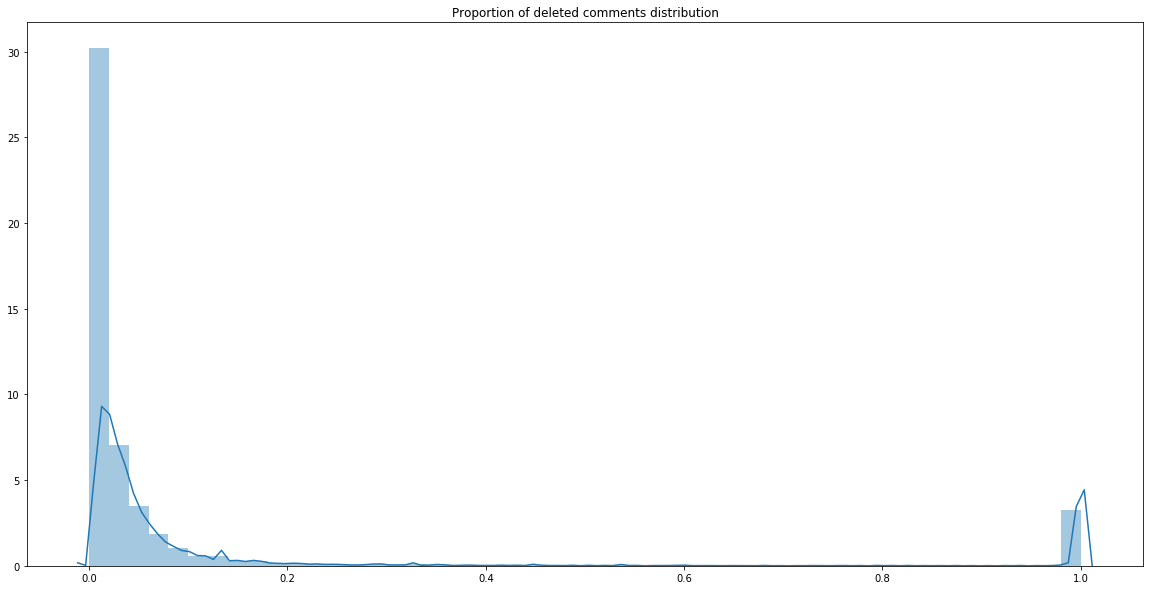

In [417]:
sns.distplot(deleted_interactions_grouped['proportion_low'].values)
plt.title("Proportion of deleted comments distribution")

### After removing  the subreddits that delete all their comments (proportion is 1), other subreddits that delete most of their comments they seem to be similar to the ones identified beforehand

In [124]:
deleted_interactions_grouped[deleted_interactions_grouped.proportion_low!=1].sort_values(by='proportion_low', ascending=False).head(10)

,deleted_comments,total_comments,proportion,proportion_low
subreddit,,,,
SoCcErs4k,10927,10928,0.999908,0.999729
liveTvUs,23853,23857,0.999832,0.999668
BillsColtsLive,8184,8185,0.999878,0.999638
ufc230livehd,22310,22317,0.999686,0.999454
ChargersTitansLive,8028,8030,0.999751,0.999406
ChiefsPatriotsLivess,4523,4524,0.999779,0.999346
BearsDolphinsLive,4119,4120,0.999757,0.999282
BuccaneersFalconsLive,4102,4103,0.999756,0.999279
Gamenfllivehd,7201,7204,0.999584,0.999112


### A scatterplot between the proportion and the total of comments helps us to understand the relationship between them, for the largest communities 

I will apply k-means clustering to discover groups od subreddits based on their total ammount of comments and deletion rate

In [490]:
filtered=deleted_interactions_grouped[deleted_interactions_grouped.total_comments>2000]

In [491]:
filtered.shape

(4654, 4)

In [492]:
filtered.nlargest(20, columns=['proportion_low','total_comments'])

,deleted_comments,total_comments,proportion,proportion_low
subreddit,,,,
nfltodaygames,19676,19676,1.0,1.0
UFC230Liv,17591,17591,1.0,1.0
BroncosCardinalsLive,12274,12274,1.0,1.0
SaintsVikingsLivee,7261,7261,1.0,1.0
UFC229LiveHD,6334,6334,1.0,1.0
EaglesJaguarsLives,5921,5921,1.0,1.0
NFLweekupdate,5217,5217,1.0,1.0
NFLusa,5205,5205,1.0,1.0
ColtsJetsLive,4618,4618,1.0,1.0


In [493]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()

In [494]:
X=scaler.fit_transform(filtered[['total_comments','proportion_low']])

In [495]:
X

array([[-0.16643772, -0.04201841],
       [-0.26206408, -0.57110206],
       [ 1.02441618, -0.39124515],
       ...,
       [ 2.1589046 ,  2.53292994],
       [ 0.31878407,  0.99990535],
       [-0.21589046, -0.70547795]])

In [496]:
from sklearn.cluster import KMeans

In [497]:
# Run k-means for coloring identified groups
labels = KMeans(init='k-means++', n_clusters=6).fit_predict(X)

In [498]:
len(np.unique(labels))

6

In [499]:
palette = d3['Category10'][len(np.unique(labels))]

In [500]:
colors = [palette[x] for x in labels]

In [501]:
source = ColumnDataSource(
        data=dict(
            x=filtered['total_comments'],
            y=filtered['proportion_low'],
            desc=filtered.index,
            label=labels,
            colors=colors
        )
    )

In [502]:
hover = HoverTool(
        tooltips=[
            ("index", "$index"),
            ("(x,y)", "($x, $y)"),
             ("group", "@label"),
            ("desc", "@desc"),
        ]
    )

In [503]:
p = figure(plot_width=1000, plot_height=500, x_axis_type="log", tools=[hover], title="Total comments vs proportion of deleted comments (lower bound estimation)")

### Groups analysis  (Hover to view the subreddits name)
* Group 1 (orange) only has AskReddit, the biggest subreddit in terms of comments and with similar rates of deleted comments when compared to comparable communities. 
* Group 3 (red) has the next largest subreddit: Politics, with a similar deletion rate
* Group 2 (green) has other big subreddits, from this group news stands out, deleting almost 20% of their comments.
* Group 5 (brown) starts to show instances with larger rates of deleted comments, TwoXChromosomes and science delete around 40% of their comments.
* Group 4 (purple) encompasses the subreddits where more than half of the comments were deleted, the largest communities of this group are photoshopbattles and play4k, play4k is an streaming subreddit with a 90% deletion rate
* Group 0 (blue) has the rest of the subreddits, not as much participation and not as much deletion rate

In [504]:
p.scatter('x', 'y', size=8, source=source, fill_color='colors')
show(p)

In [473]:
del source

In [505]:
filtered['label']=labels

/home/profesor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [506]:
filtered_g4=filtered[filtered.label==4]

In [507]:
filtered_g4.nlargest(15, columns=['total_comments','proportion_low'])

,deleted_comments,total_comments,proportion,proportion_low,label
subreddit,,,,,
Play4K,34741,37526,0.925785,0.923133,4
photoshopbattles,18227,34688,0.525455,0.520201,4
liveTvUs,23853,23857,0.999832,0.999668,4
ufc230livehd,22310,22317,0.999686,0.999454,4
nfltodaygames,19676,19676,1.000000,1.000000,4
UFC230Liv,17591,17591,1.000000,1.000000,4
nflgamesday,17280,17332,0.997000,0.996186,4
sportsonlinetv,13392,13429,0.997245,0.996358,4
NCAAFootball18,12841,12851,0.999222,0.998740,4


### Let's do an analysis of the names of the subreddits of this group 4 to confirm that these are the communities for streaming live events  

Grant Jenks'   [wordsegment](http://www.grantjenks.com/docs/wordsegment/api.html) library can help in this taks by splitting the subreddits' names

In [509]:
from wordsegment import load, segment
load()

In [515]:
words_series=filtered_g4.index.map(lambda x: list(wordsegment.segment(str.lower(x))))

In [516]:
flatten_words = lambda l: [item for sublist in l for item in sublist]

In [517]:
word_freq=pd.DataFrame(np.array(np.unique( flatten_words(words_series), return_counts=True)).T, columns=['word','freq'])
word_freq['freq']=word_freq['freq'].astype(int)

### As seen by the word frequency, live, tv and nfl team names are prevalent in this period of time for this subreddits

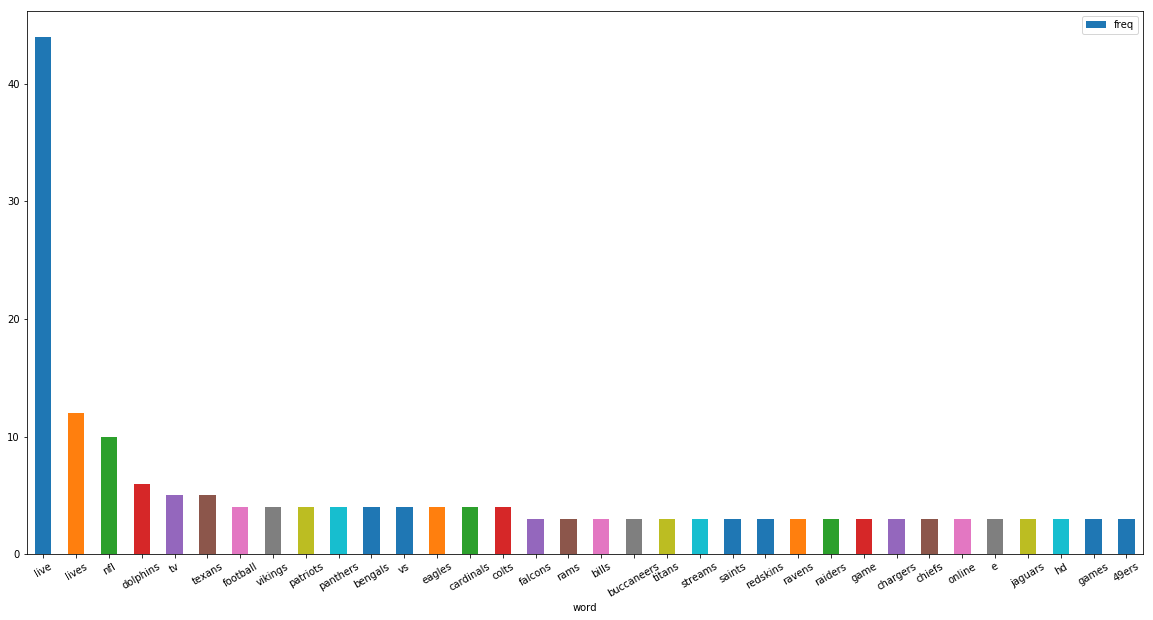

In [518]:
word_freq[word_freq.freq>2].sort_values(by='freq', ascending=False).plot.bar(x='word', y='freq', rot=30)

### In the first version of this analysis I had removed all deleted comments, now the filtered_g4 dataframe contains one group of similar subreddits

In [519]:
del word_freq
del flatten_words
del load, segment

In [534]:
del words_series

In [530]:
del filtered

In [524]:
del deleted_interactions_grouped

In [520]:
df_interactions.shape

(112183892, 4)

In [522]:
df_interactions=df_interactions[df_interactions.author!='[deleted]']

In [523]:
df_interactions.shape

(104275152, 4)

In [538]:
grouped_author.drop('[deleted]',axis=0, inplace=True)

### One way to consider two subreddits similar its by users co-commenting, I'm going to remove all comments from users that only comment in one subreddit, almost 50% of all users only have commented on one subreddit

In [543]:
grouped_author[grouped_author.how_many_subs==1].index

Index(['*polhold00214', '------------------O', '----------_-_', '-------_---',
       '-------jem', '------J------', '------MJ------', '------____--',
       '-----60-09', '-----NSA-----',
       ...
       'zzzzzzarah', 'zzzzzzgrt', 'zzzzzzp0', 'zzzzzzzssz', 'zzzzzzzzaakjs',
       'zzzzzzzzki', 'zzzzzzzztrewq', 'zzzzzzzzzx', 'zzzzzzzzzzninja',
       'zzzzzzzzzzzzzddq'],
      dtype='object', name='author', length=2325909)

In [546]:
df_interactions=df_interactions[~df_interactions.author.isin(grouped_author[grouped_author.how_many_subs==1].index)]

In [547]:
df_interactions.shape

(95444921, 4)

In [548]:
grouped_author=grouped_author[grouped_author.how_many_subs>1]

In [549]:
grouped_author.shape

(2974723, 5)

In [560]:
top_200_authors=grouped_author.nlargest(n=200, columns='count_times').reset_index()

### AutoModerator is another bot that has a lot of interactions, since its a tool that subreddit admins use to help them monitor their subreddits 

It has as many comments as the next 199 users,  its not relevant for the study so I will remove it

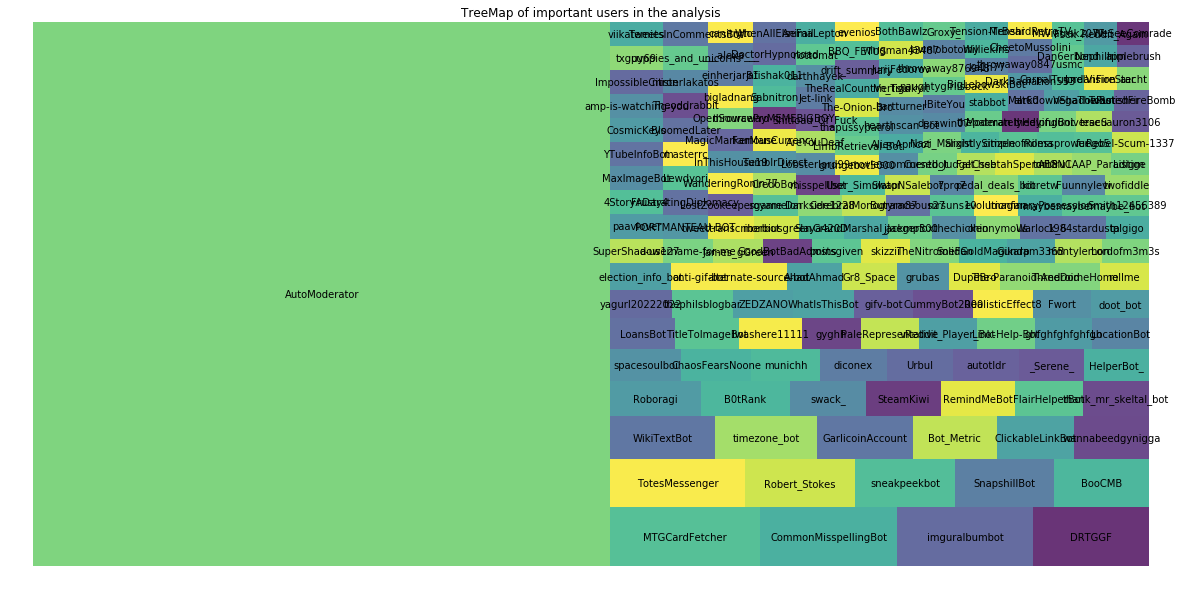

In [562]:
squarify.plot(sizes=top_200_authors['count_times'], label=top_200_authors['author'], alpha=.8)
plt.axis('off')
plt.title("TreeMap of important users in the analysis")
plt.show()

In [564]:
grouped_author.drop('AutoModerator',axis=0, inplace=True)

In [565]:
df_interactions=df_interactions[df_interactions.author!='AutoModerator']

In [567]:
df_interactions.shape

(94325457, 3)

In [566]:
grouped_author.to_pickle('./data/grouped_temp.pickle')

In [571]:
df_interactions.to_pickle('./data/df_interactions_temp.pickle')

In [581]:
filtered_g4.to_pickle('./data/df_filteredg4.pickle')

In [576]:
del top_200_authors

### There's still a lot of interactions that come from bots. I'll try to identify them in order to only keep the interactions of real users, I'm going to extract features to detect bots
* Detect if it has bot in their name
* Is the author commenting on many subreddits
* Is it commenting on very brief timespans 

In [190]:
def diff_stats(series):
    s=series.sort_values().diff().dropna()
    return (s.mean(),s.min(),s.std())

    

In [191]:
grouped_ext=df_interactions[df_interactions.author.isin(grouped_author.index)].groupby('author').agg({'created':diff_stats})

In [192]:
grouped_ext['created_mean']=grouped_ext['created'].apply(lambda x: x[0])

In [193]:
grouped_ext['created_min']=grouped_ext['created'].apply(lambda x: x[1])

In [194]:
grouped_ext['created_std']=grouped_ext['created'].apply(lambda x: x[2])

In [195]:
del grouped_ext['created']

In [196]:
grouped_ext.head()

,created_mean,created_min,created_std
author,,,
-------------------7,227741.454545,40232.0,259740.089393
-------------------c,81984.933333,21.0,152279.058999
-------------------x,169598.500000,445.0,239219.173823
---------------h,178338.800000,162.0,312234.153151
-----------0,219462.625000,94.0,414214.024567


In [197]:
# Users that have 'bot' in their name
from wordsegment import load, segment
load()

In [198]:
grouped_author['separated']=grouped_author.index.map(lambda x: set(segment(str.lower(x))))

In [199]:
grouped_author['has_bot']=grouped_author['separated'].apply(lambda x : 'bot' in x or 'bots' in x)

In [200]:
grouped_author['has_bot']=  (grouped_author['has_bot']==True) | (grouped_author.index.map(lambda x: "b0t" in str.lower(x)).values)

In [201]:
grouped_author['high_count']=grouped_author['count_times']>=1489

In [202]:
grouped_author=grouped_author.join(grouped_ext)

In [261]:
grouped_author.sort_values(by='count_times', ascending=False).head(100)

,count_times,subreddit,author_created_utc,controversiality,how_many_subs,separated,has_bot,high_count,created_mean,created_min,created_std
author,,,,,,,,,,,
MTGCardFetcher,31186,"{shittyjudgequestions, HollowKnightMemes, Gobl...",1.396613e+09,0.000096,69,"{fetcher, card, mtg}",False,True,85.885265,0.0,106.408909
CommonMisspellingBot,28507,"{xfce, masturbationquestions, BotsScrewingUp, ...",1.488799e+09,0.084190,7770,"{bot, common, misspelling}",True,True,93.949975,0.0,109.249102
imguralbumbot,28435,"{Dirtbikes, DelawareOH, AnimalRights, TheGreat...",1.494883e+09,0.001477,7037,"{bot, img, album, ur}",True,True,94.190793,0.0,146.845121
DRTGGF,24098,"{TheWalkingDeadS9, Week5NFLGameLive, UFC229Liv...",1.528975e+09,0.000000,3,"{drt, ggf}",False,True,31.516662,0.0,4260.546727
TotesMessenger,23275,"{Dirtbikes, manhwa, AnimalRights, army, missm3...",1.421290e+09,0.006273,6749,"{messenger, totes}",False,True,115.063032,0.0,268.795085
Robert_Stokes,19038,"{soccerstreams, Streambyreddit, championsleagu...",1.534347e+09,0.000000,5,"{robert, stokes}",False,True,113.404370,1.0,5993.055955
sneakpeekbot,17392,"{Dirtbikes, bapccanada, legs, LateStageSociali...",1.483197e+09,0.005807,4526,"{bot, peek, sneak}",True,True,153.996320,0.0,2639.626000
SnapshillBot,17125,"{RPDRDRAMA, EnoughCommieSpam, AgainstHateSubre...",1.420514e+09,0.002803,54,"{bot, hill, snaps}",True,True,156.400549,2.0,179.730340
BooCMB,16443,"{xfce, masturbationquestions, BotsScrewingUp, ...",1.539237e+09,0.067202,5937,"{boo, cmb}",False,True,107.458278,0.0,503.207368


In [223]:
grouped_author.sort_values(by='how_many_subs', ascending=False).head(50)

,count_times,subreddit,author_created_utc,controversiality,how_many_subs,separated,has_bot,high_count,created_mean,created_min,created_std
author,,,,,,,,,,,
CommonMisspellingBot,28507,"{xfce, masturbationquestions, BotsScrewingUp, ...",1.488799e+09,0.084190,7770,"{bot, common, misspelling}",True,True,93.949975,0.0,109.249102
imguralbumbot,28435,"{Dirtbikes, DelawareOH, AnimalRights, TheGreat...",1.494883e+09,0.001477,7037,"{bot, img, album, ur}",True,True,94.190793,0.0,146.845121
TotesMessenger,23275,"{Dirtbikes, manhwa, AnimalRights, army, missm3...",1.421290e+09,0.006273,6749,"{messenger, totes}",False,True,115.063032,0.0,268.795085
BooCMB,16443,"{xfce, masturbationquestions, BotsScrewingUp, ...",1.539237e+09,0.067202,5937,"{boo, cmb}",False,True,107.458278,0.0,503.207368
sneakpeekbot,17392,"{Dirtbikes, bapccanada, legs, LateStageSociali...",1.483197e+09,0.005807,4526,"{bot, peek, sneak}",True,True,153.996320,0.0,2639.626000
Bot_Metric,12798,"{waze, Dirtbikes, zrxtrader, science2, wemeton...",1.525002e+09,0.002188,4457,"{metric, bot}",True,True,209.272408,0.0,214.718351
B0tRank,11138,"{EngineBuilding, Dirtbikes, WearOS, ThatsHowTh...",1.534110e+09,0.019662,3812,{b0trank},True,True,240.488821,1.0,259.155062
WikiTextBot,15890,"{WearOS, Existential_crisis, ThatsHowThingsWor...",1.496577e+09,0.002014,3733,"{bot, wikitext}",True,True,168.550507,1.0,172.324583
ClickableLinkBot,11747,"{WearOS, ThatsHowThingsWork, soccergifs, Minio...",1.503784e+09,0.002979,3348,"{bot, clickable, link}",True,True,227.692065,0.0,793.019170


### By looking  the top 50 list most of the authors by number of posts and subreddit counts have posted with 0 seconds between the posts. 

* By looking the number of users that have  bot in their name there are only 2485 users, however there are around 41k users that posted within less than 5 seconds, which might indicate they are bots.

* By  looking at the top 50 elements, I'll search for thresholds on the extracted features that in my opinion could identify a bot. Small minimum timespan between posts, a high count of comments, or commenting on many subreddits

In [437]:
np.sum(grouped_author.created_min<=5)

41470

In [204]:
grouped_author.count_times.describe()

count    2.974722e+06
mean     3.170900e+01
std      9.593850e+01
min      2.000000e+00
25%      4.000000e+00
50%      9.000000e+00
75%      2.600000e+01
max      3.118600e+04
Name: count_times, dtype: float64

In [308]:
np.percentile(grouped_author.count_times, 99)

351.0

In [330]:
grouped_author.how_many_subs.describe()

count    2.974722e+06
mean     6.797950e+00
std      1.406915e+01
min      2.000000e+00
25%      2.000000e+00
50%      4.000000e+00
75%      7.000000e+00
max      7.770000e+03
Name: how_many_subs, dtype: float64

In [331]:
np.percentile(grouped_author.how_many_subs, 99.5)

57.0

In [312]:
np.percentile(grouped_author.created_min, 1)

5.0

In [299]:
grouped_author.created_min.describe()

count    2.974722e+06
mean     1.118085e+05
std      3.323417e+05
min      0.000000e+00
25%      4.600000e+01
50%      2.110000e+02
75%      1.287800e+04
max      2.676202e+06
Name: created_min, dtype: float64

In [303]:
grouped_author.created_mean.describe()

count    2.974722e+06
mean     2.696156e+05
std      3.452019e+05
min      1.000000e+00
25%      6.037716e+04
50%      1.507014e+05
75%      3.338294e+05
max      2.676202e+06
Name: created_mean, dtype: float64

In [206]:
grouped_author.to_pickle('./data/grouped_temp2.pickle')

In [310]:
np.sum((grouped_author.created_min<8) & (grouped_author.count_times>=129))

31441

In [302]:
31441/len(grouped_author.created_min)

0.010569391022085425

### According to this estimation at least 1% of the users are bots and the extracted feature 'has_bot' in name is not working.  I'll try to create a classifier based the features mentioned beforehand

* Label authors with many comments as bots
* Label authors with many subreddits as bots
* Label authors with low commenting minimum between posts as bots
* Label authors that have waited above the mean minimum time as not bots

In [398]:
atleast_10=grouped_author.loc[(grouped_author.count_times>=10)][['count_times','how_many_subs','created_mean','created_min','created_std','has_bot']]

In [399]:
len(atleast_10)

1475172

In [400]:
grouped_author.created_min.describe()

count    2.974722e+06
mean     1.118085e+05
std      3.323417e+05
min      0.000000e+00
25%      4.600000e+01
50%      2.110000e+02
75%      1.287800e+04
max      2.676202e+06
Name: created_min, dtype: float64

In [401]:
atleast_10['labels']=-1

In [402]:
#Label top authors as bots
atleast_10.loc[ grouped_author.count_times>=351 ,'labels']=1

In [403]:
#Label authors that post in many subs as bots
atleast_10.loc[ grouped_author.how_many_subs>=55 ,'labels']=1

In [404]:
#Label authors that post within short timespans as bots
atleast_10.loc[ grouped_author.created_min<=5 ,'labels']=1

In [405]:
#Label authors that wait at least 50%   
atleast_10.loc[atleast_10.created_min>=211,'labels']=0

### This scenario is similar to a semi-supervised scenario, where I have placed the labels on some of the authors but most of them have no label

Ill learn a logistic binary classifier on the labeled data using skleanrs cross validation, and check how all elements are being classified. I'll only use the bot label for examples where the probability  of the label is high

In [406]:
atleast_10.labels.value_counts()

-1    1135433
 0     268188
 1      71551
Name: labels, dtype: int64

In [407]:
from sklearn.linear_model import LogisticRegressionCV

In [408]:
labeled_dataset=atleast_10[atleast_10.labels!=-1]

In [409]:
clf = LogisticRegressionCV(cv=5, random_state=0, max_iter=10000, n_jobs=-1).fit(labeled_dataset[['count_times','how_many_subs','created_mean','created_min','created_std','has_bot']], labeled_dataset['labels'])

In [410]:
result_prob=clf.predict_proba(atleast_10[['count_times','how_many_subs','created_mean','created_min','created_std','has_bot']])

In [411]:
atleast_10['prob_0']=result_prob[:,0]

In [412]:
atleast_10['prob_1']=result_prob[:,1]

In [413]:
atleast_10['predicted_label']=atleast_10.apply(lambda x: 1 if x['prob_1']> x['prob_0'] else 0 ,axis=1)

In [414]:
atleast_10.predicted_label.value_counts()

1    934283
0    540889
Name: predicted_label, dtype: int64

In [415]:
atleast_10['prob']=atleast_10[['prob_1','prob_0']].max(axis=1)

In [416]:
atleast_10.sort_values(by='prob')

,count_times,how_many_subs,created_mean,created_min,created_std,has_bot,labels,prob_0,prob_1,predicted_label,prob
author,,,,,,,,,,,
defendersoftheouter,27,5,92370.769231,76.0,93484.018842,False,-1,0.500004,4.999955e-01,0,0.500004
pcmasterthrow,17,2,8313.187500,25.0,32172.771146,False,-1,0.500007,4.999935e-01,0,0.500007
Eave22,28,4,46805.851852,64.0,138459.822875,False,-1,0.500007,4.999933e-01,0,0.500007
TisteAndii,20,13,118783.263158,91.0,193827.071964,False,-1,0.499989,5.000109e-01,1,0.500011
amdnim,33,18,75863.406250,80.0,122486.857546,False,-1,0.500013,4.999866e-01,0,0.500013
quellik,45,24,57219.045455,86.0,125187.866996,False,-1,0.500014,4.999860e-01,0,0.500014
etzerodt,10,3,259654.777778,161.0,419017.666681,False,-1,0.500016,4.999842e-01,0,0.500016
Hohohosuckmydick,24,2,7245.652174,30.0,14845.799166,False,-1,0.500019,4.999814e-01,0,0.500019
missingpiece,46,14,56518.866667,89.0,151315.853544,False,-1,0.499972,5.000278e-01,1,0.500028


In [431]:
atleast_10["prob1_cat"]=pd.cut(atleast_10.prob_1,[0,0.8,1])

In [432]:
atleast_10["prob1_cat"].value_counts()

(0.8, 1.0]    847932
(0.0, 0.8]    609899
Name: prob1_cat, dtype: int64

In [433]:
atleast_10['log_count_times']=np.log(atleast_10.count_times)

In [434]:
atleast_10['log_how_many_subs']=np.log(atleast_10.how_many_subs)

### These users were initially labeled as bots since they had a lot of visited subreddits, however by the results of the model the probability is not high, on a manual inspections these users with a high number of interactions seem to be authentic users. In the pairplot and boxplots its easier to see the characterization of the bots made by the model


In [440]:
atleast_10[(atleast_10['labels']==1) & (atleast_10['prob_1']<0.8)].sort_values(by='count_times', ascending=False)

,count_times,how_many_subs,created_mean,created_min,created_std,has_bot,labels,prob_0,prob_1,predicted_label,prob,prob1_cat,log_count_times,log_how_many_subs
author,,,,,,,,,,,,,,
Drews232,119,59,22073.101695,197.0,27692.533954,False,1,0.991331,0.008669,0,0.991331,"(0.0, 0.8]",4.779123,4.077537
Besquiter,110,64,23506.724771,119.0,36022.970717,False,1,0.217145,0.782855,1,0.782855,"(0.0, 0.8]",4.700480,4.158883
Invisinak,107,65,25151.707547,119.0,40091.723811,False,1,0.247291,0.752709,1,0.752709,"(0.0, 0.8]",4.672829,4.174387
justalurker750,107,55,24468.594340,176.0,41427.245415,False,1,0.978871,0.021129,0,0.978871,"(0.0, 0.8]",4.672829,4.007333
Metalatitsfinest,103,57,24463.225490,114.0,34746.761683,False,1,0.258166,0.741834,1,0.741834,"(0.0, 0.8]",4.634729,4.043051
Sthurlangue,95,57,28318.085106,108.0,41037.898491,False,1,0.261373,0.738627,1,0.738627,"(0.0, 0.8]",4.553877,4.043051
GodEmperorGummy,93,67,28271.695652,110.0,33732.307258,False,1,0.336878,0.663122,1,0.663122,"(0.0, 0.8]",4.532599,4.204693
Redsneeks3000,90,58,29954.561798,104.0,46351.023772,False,1,0.260543,0.739457,1,0.739457,"(0.0, 0.8]",4.499810,4.060443
Sinisphere,90,55,29413.966292,109.0,43222.071041,False,1,0.366281,0.633719,1,0.633719,"(0.0, 0.8]",4.499810,4.007333


### In this pairplot we can observe some interesting relationships
* Calculated log of count times and log of number of subreddits in order to visualize better the effects
* There seems to be a linear relationship between the number of subreddits and the number of comments a user has, in terms of bots, no relationship is easily discernable
* Distributions of the variable vs a high probability of being a bot according to the model seem to be different for the chosen features, I will explore this in boxplots.
* The minimum time between posts seem to be the threshold most noticeable on the distributions.

/home/profesor/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 0.98, 'Pairplot of author features with probability of being a bot')

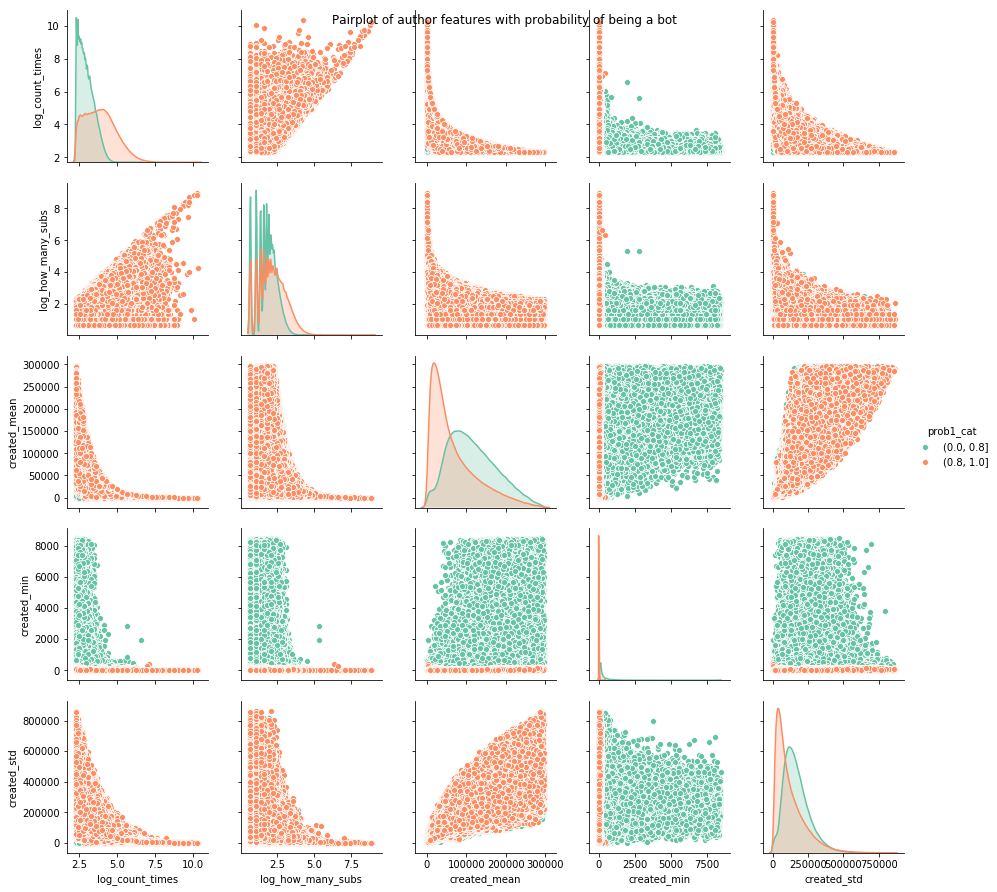

In [435]:
g=sns.pairplot(atleast_10[['log_count_times','log_how_many_subs','created_mean','created_min','created_std','prob1_cat']],hue='prob1_cat',diag_kind='kde', palette=sns.color_palette("Set2"))
g.fig.suptitle("Pairplot of author features with probability of being a bot")

### As expected, the number of comments is higher for users with high-confidence of being a bot, however there are some authors that have a lot of comments (e^6.7 ~ 800 comments) where the model doesn't have high confidence of detecting a bot

Text(0.5, 1.0, "Boxplot for number of comments for authors that have bot in their name (True) vs those who don't (False)")

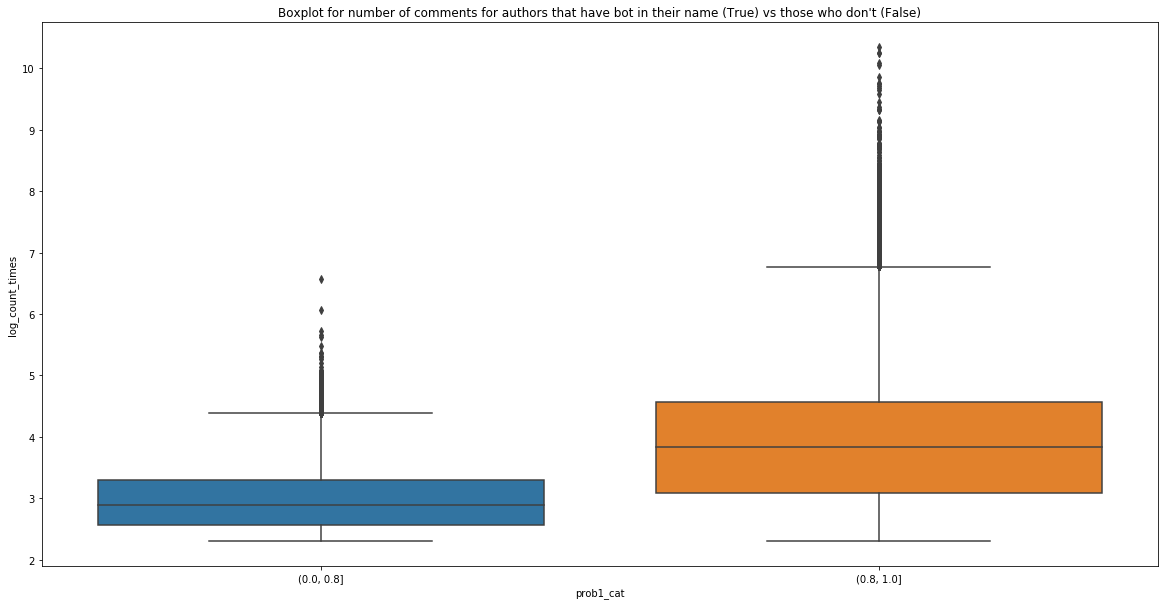

In [442]:
sns.boxplot(data=atleast_10,y='log_count_times', x='prob1_cat')
plt.title("Boxplot for number of log comments for authors vs probability of bot")

### The same happens with the subs, all the authors with a high number of subreddits seem to be classified with high confidence as a bot, however some authors that have commented in many subreddits are not classified as bots

Text(0.5, 1.0, 'Boxplot for number of log subreddit count for authors')

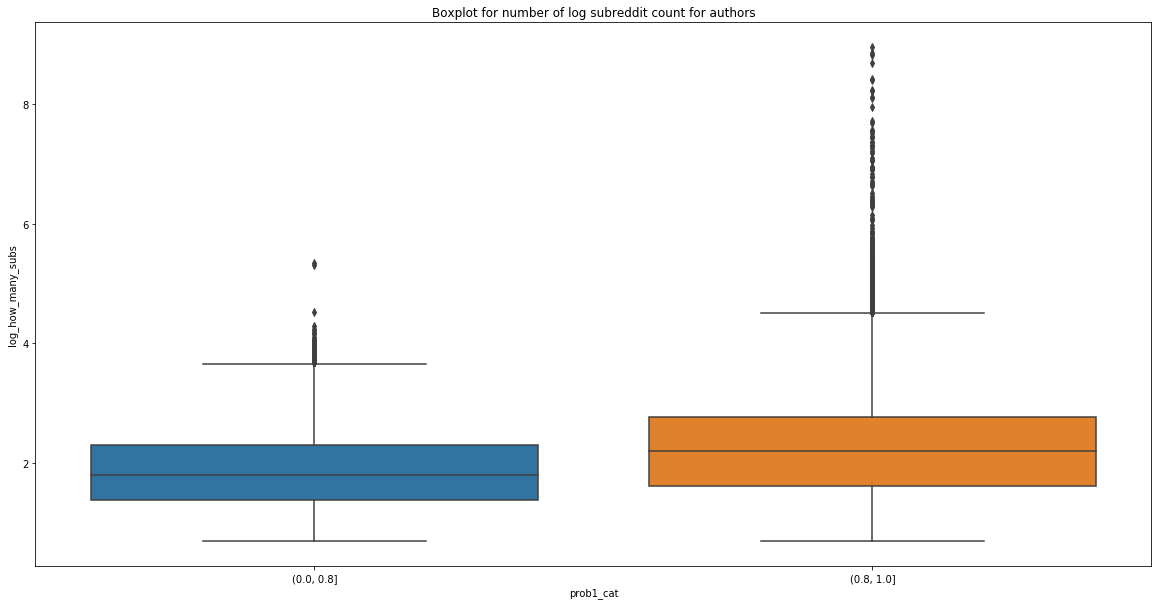

In [444]:
sns.boxplot(data=atleast_10,y='log_how_many_subs', x='prob1_cat')
plt.title("Boxplot for number of log subreddit count for authors vs probability of bot")

### Average of time between posts is lower for bots

Text(0.5, 1.0, 'Boxplot for the created mean vs probability of bot')

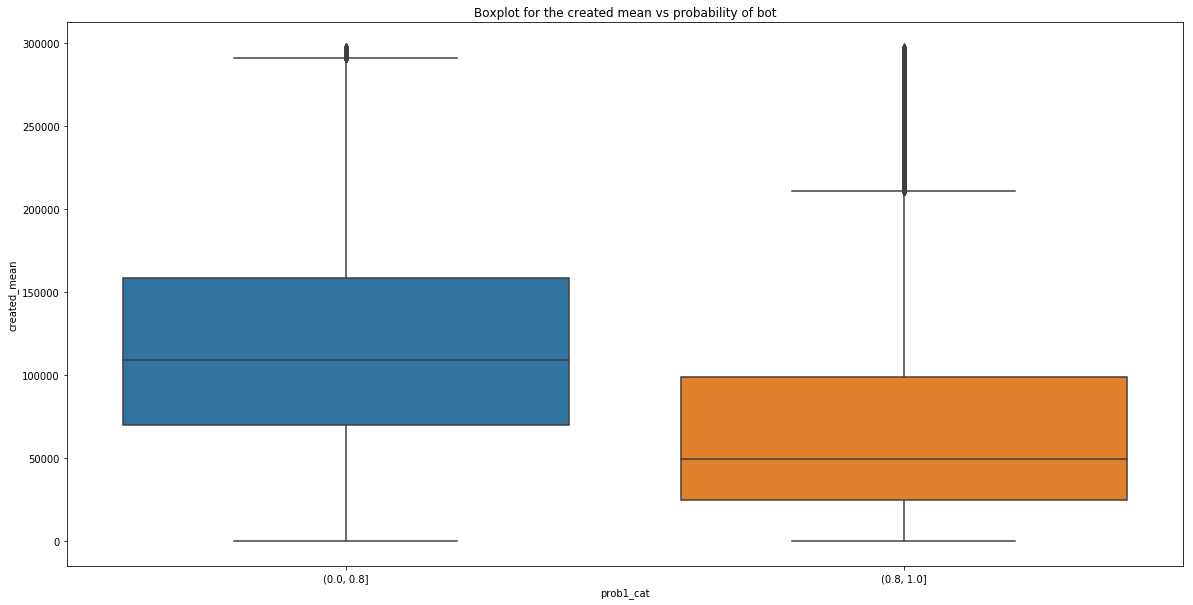

In [446]:
sns.boxplot(data=atleast_10,y='created_mean', x='prob1_cat')
plt.title("Boxplot for the created mean vs probability of bot")

### Minimum difference between posts is nearly 0 for bots

Text(0.5, 1.0, 'Boxplot for minimum time between comments for authors vs probability of bot')

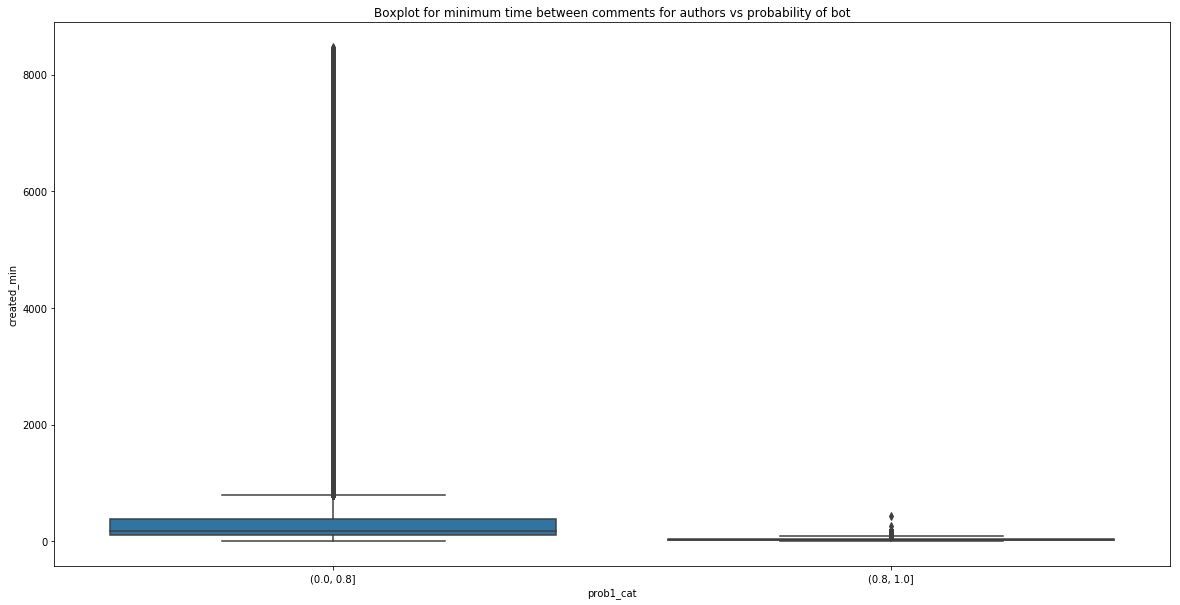

In [448]:
sns.boxplot(data=atleast_10,y='created_min', x='prob1_cat')
plt.title("Boxplot for minimum time between comments for authors vs probability of bot")

### Finally, bots seem to be more consistent in their posting rate, having a lower standard deviation than non-bots, which was also expected

Text(0.5, 1.0, 'Boxplot for the std time between comments for authorsvs probability of bot')

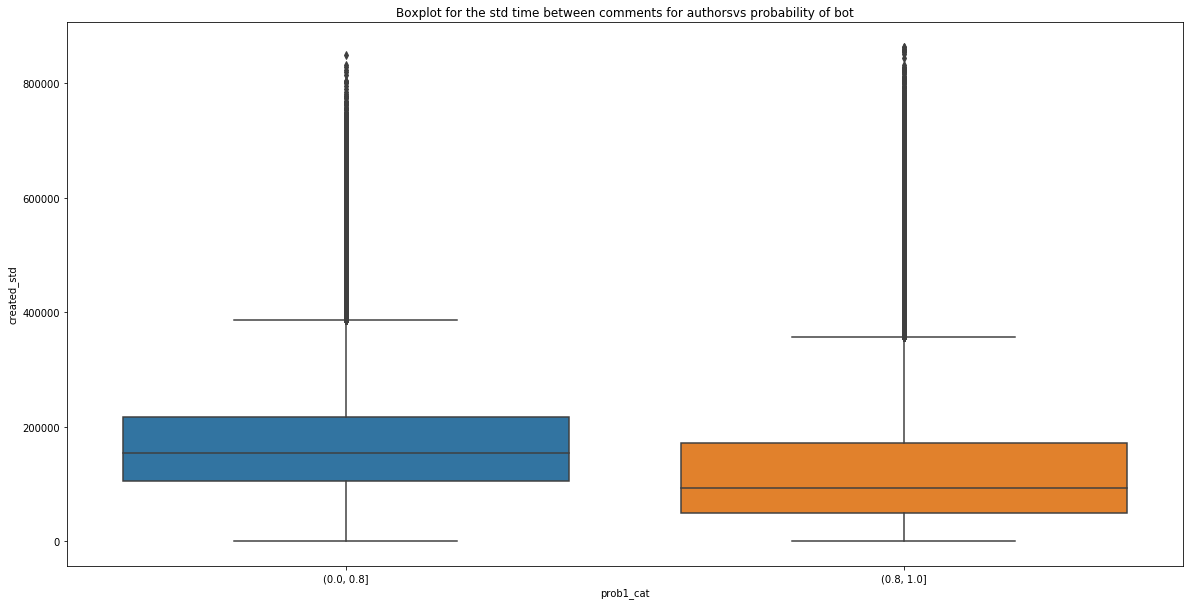

In [449]:
sns.boxplot(data=atleast_10,y='created_std', x='prob1_cat')
plt.title("Boxplot for the std time between comments for authorsvs probability of bot")

In [455]:
atleast_10.to_pickle('./data/atleast10_analysis.pickle')

### After detecting bots, i'm keeping only interactions from the estimated non-bots for the rest of the analysis.

In [451]:
non_bot_authors=atleast_10.loc[atleast_10.prob_1<.8].index

In [452]:
len(non_bot_authors)

627240

In [453]:
df_interactions=df_interactions[df_interactions.author.isin(non_bot_authors)]

In [454]:
df_interactions.shape

(13832144, 3)

In [459]:
df_interactions.to_pickle('./data/interactions_final_analysis.pickle')

In [457]:
grouped_author=grouped_author[grouped_author.index.isin(non_bot_authors)]

In [458]:
grouped_author.shape

(627240, 11)

In [461]:
grouped_author.to_pickle('./data/grouped_author_final.pickle')

### Lets compared how the top subreddits in comments have changed after removing the bots. This is a copy of the original top 20 list of most commented subreddits and in the next cell the current count after removing bots and deleted interactions. 

* Askreddit and politics keep their importance
* Subreddits such as the_donald,nfl, fantasyfootball dropped some positions
* The askOuija subreddit dropped from the top20 list, this particular subreddit encourages users to make frequent submissions, therefore the model classified them as bots.


In [35]:
df_interactions.subreddit.value_counts().head(20)

AskReddit            5834042
politics             2208780
nfl                  1285725
The_Donald           1207555
funny                 999457
fantasyfootball       956079
nba                   902452
leagueoflegends       886118
CFB                   882986
worldnews             834164
FortNiteBR            799807
news                  758534
pics                  717980
AskOuija              714345
gaming                693736
Blackops4             606413
soccer                586826
baseball              578326
reddeadredemption     561949
dankmemes             560701
Name: subreddit, dtype: int64

In [69]:
df_interactions.subreddit.value_counts().head(20)

AskReddit          700777
politics           212077
funny              151790
leagueoflegends    106663
gaming             101547
worldnews          101221
pics               101086
The_Donald          82701
news                81865
nfl                 79368
nba                 76780
wow                 75322
FortNiteBR          74243
todayilearned       73828
DestinyTheGame      72214
Blackops4           70237
fantasyfootball     69837
aww                 67670
Showerthoughts      62268
videos              60526
Name: subreddit, dtype: int64

### To detect the groups of similar subreddits, I'm going to apply Non-negative matrix factorization to a matrix of size (users * subreddits). The result of the factorization will give us a latent representation of users and items, and since it's non-negative, each dimension in the latent factor coud group similar subreddits.

In [39]:
authors=grouped_author.index

In [197]:
main_authors=grouped_author.count_times.nlargest(500).index

In [198]:
main_subreddits=df_interactions.subreddit.value_counts().head(500).index

In [43]:
co_visitation_group=df_interactions.groupby(['author','subreddit']).agg({'created':lambda x:1})

In [206]:
co_visitation_group.head()

created
author               subreddit                   
-------------------7 FreeGamesOnSteam           1
                     HITsWorthTurkingFor        1
                     digitalnomad               1
                     gamedev                    1
                     leanfire                   1

In [211]:
co_visitation_unindexed=co_visitation_group.reset_index()

In [214]:
co_visitation_unindexed=co_visitation_unindexed.loc[(co_visitation_unindexed.author.isin(main_authors)) & (co_visitation_unindexed.subreddit.isin(main_subreddits)) ]

In [215]:
co_visitation_unindexed.head()

,author,subreddit,created
11110,-reasonable-person-,politics,1
43514,3lfk1ng,Amd,1
43517,3lfk1ng,funny,1
43518,3lfk1ng,interestingasfuck,1
43519,3lfk1ng,pcgaming,1


### The matrix is sparse and its dense representation wont fit in memory. I will create a dense matrix of the most important users and subreddits in order to show how sparse it is

In [219]:
X=co_visitation_unindexed.pivot(index='author',columns='subreddit',values='created').fillna(0)

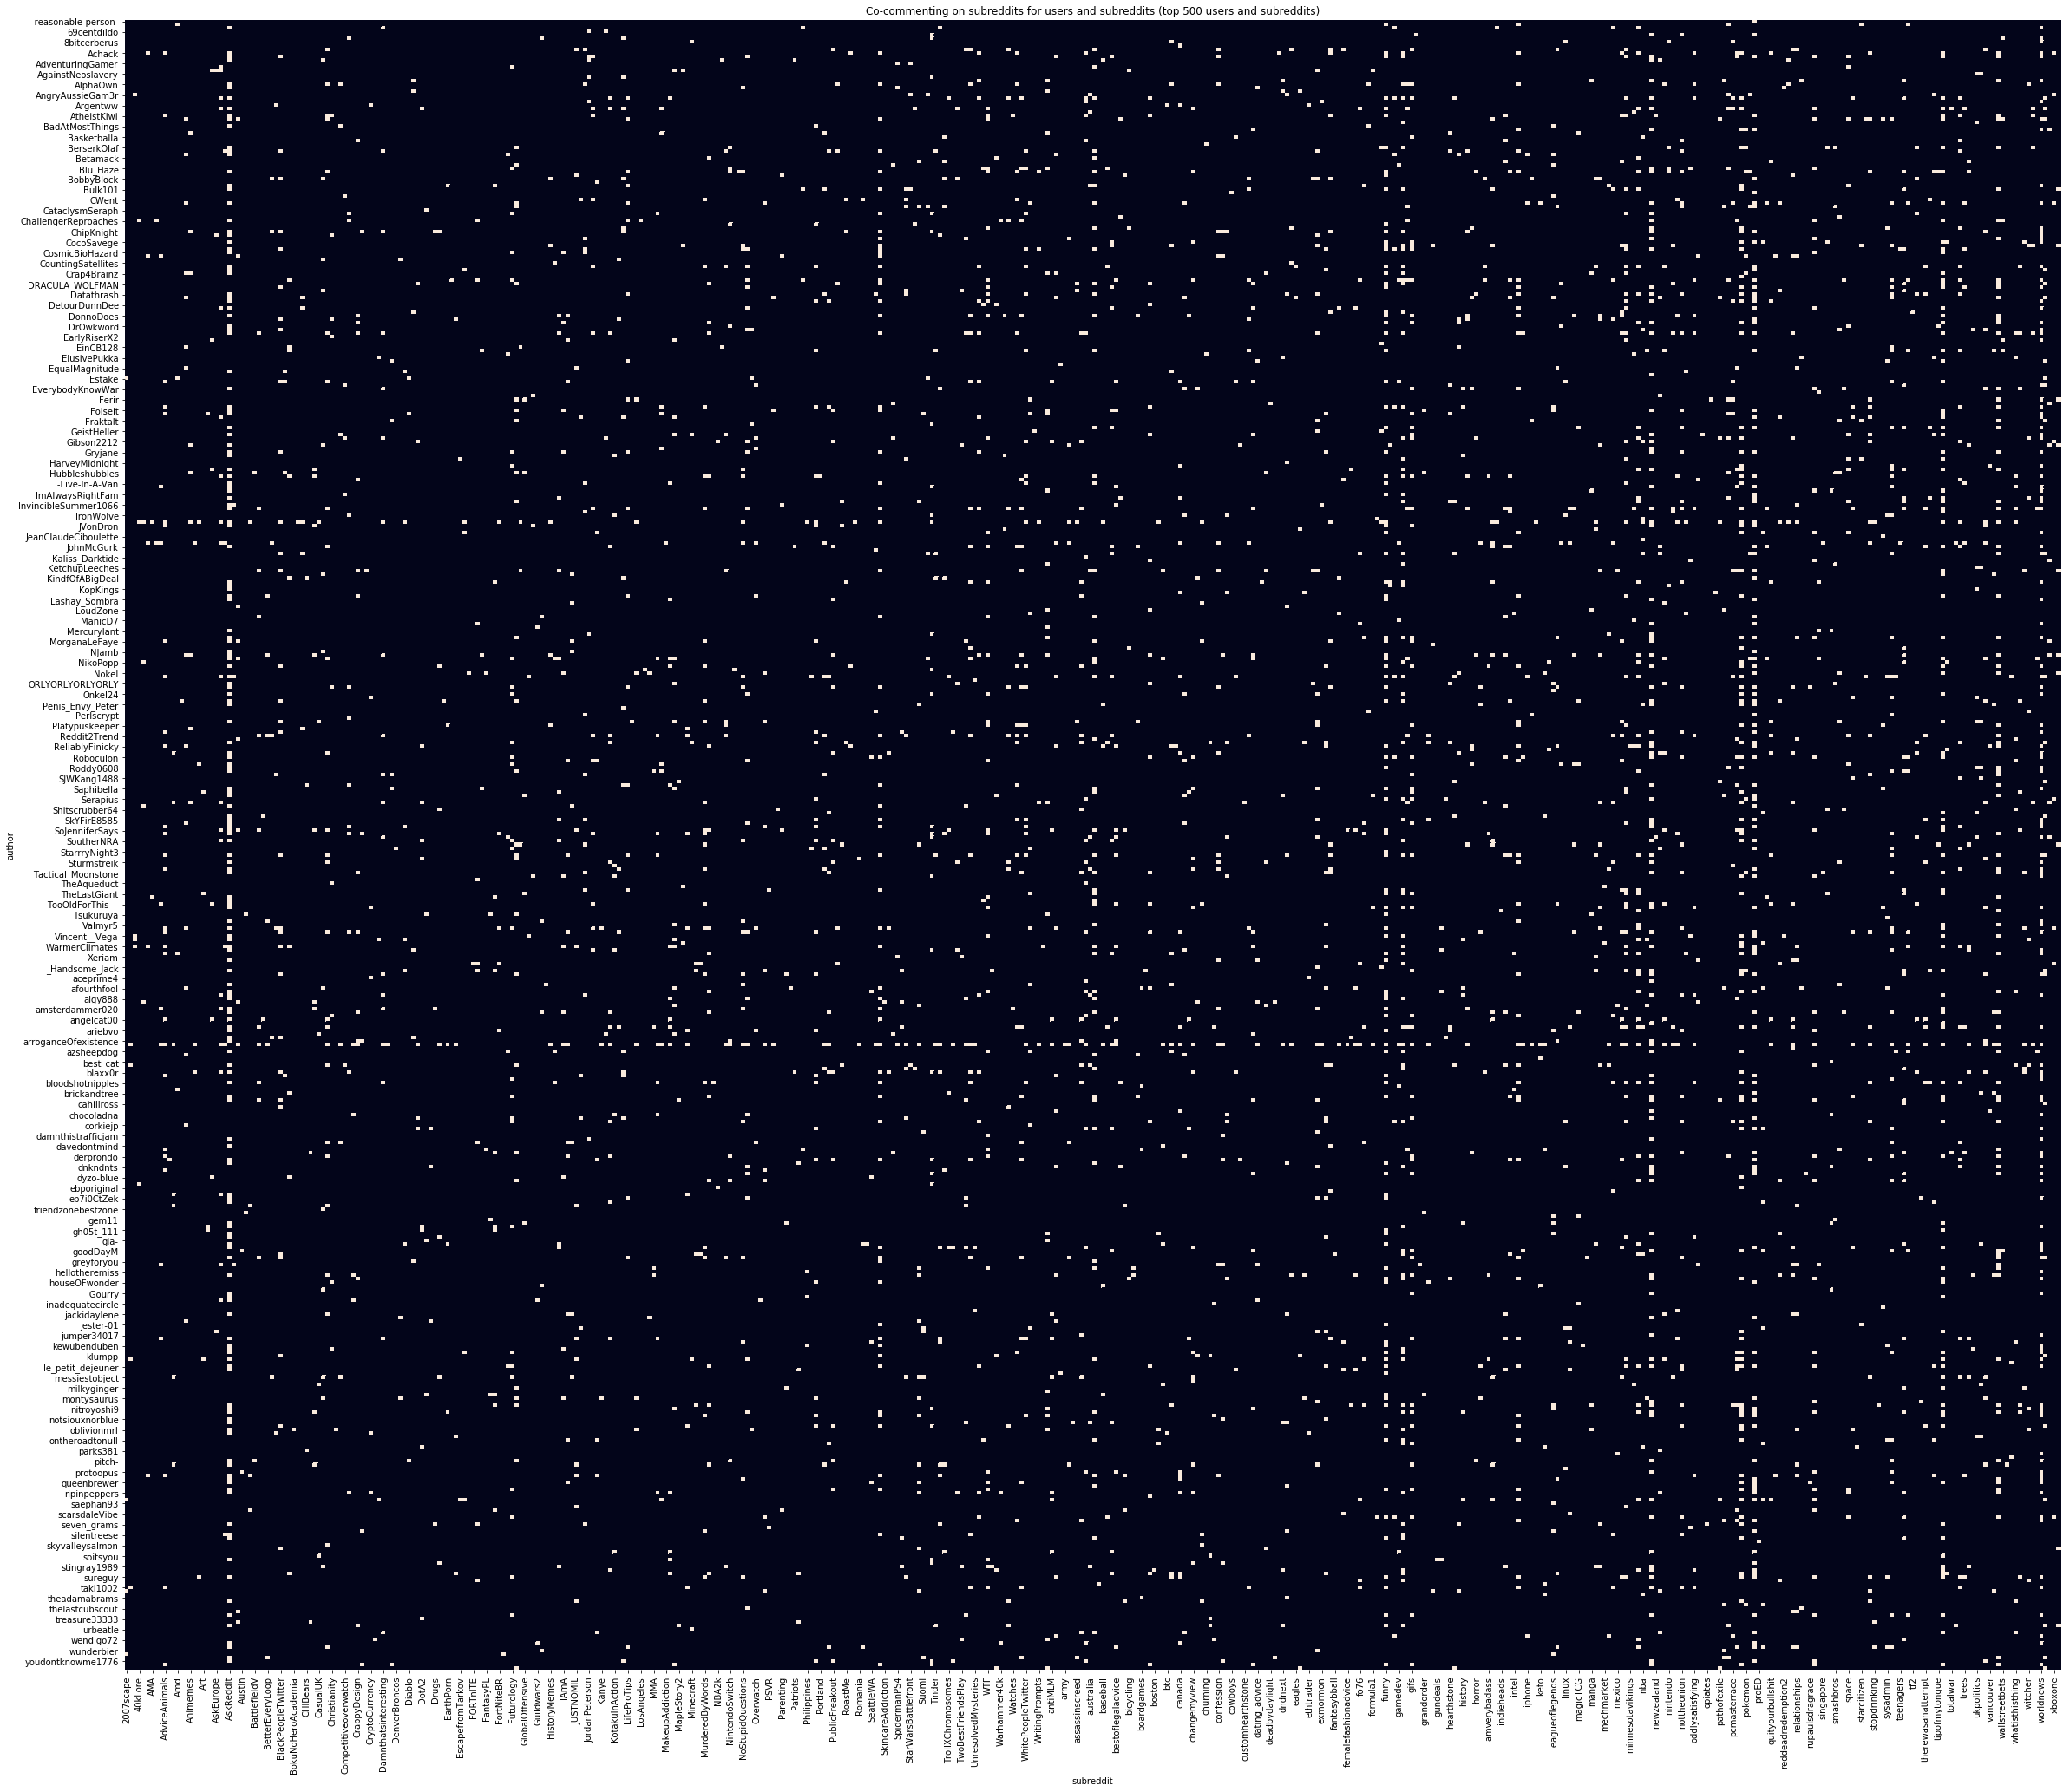

In [221]:
plt.figure(figsize=(40, 35))
ax = plt.axes()
sns.heatmap(X, cbar=False, ax = ax)
ax.set_title("Co-commenting on subreddits for users and subreddits (top 500 users and subreddits)")
plt.show()

In [194]:
#Sparse matrix
mat = sps.coo_matrix((co_visitation_group.created, (co_visitation_group.index.labels[0], co_visitation_group.index.labels[1])))

In [195]:
mat

<627240x50416 sparse matrix of type '<class 'numpy.int64'>'
	with 4675377 stored elements in COOrdinate format>

In [55]:
from sklearn.decomposition import NMF
model = NMF(n_components=10, init='random', random_state=0)

W = model.fit_transform(mat)
H = model.components_

In [92]:
mat.shape

(627240, 50416)

In [93]:
W.shape

(627240, 10)

In [152]:
type(H)

numpy.ndarray

In [153]:
H.shape

(10, 50416)

### W is the latent representation of users, a further analysis could be used to detect by this means groups of users, for example bots or latent groups of analysis

For the time being, I'm going to leave their analysis to future work

In [95]:
df_w=pd.DataFrame(W)

In [96]:
df_w['author']=co_visitation_group.index.levels[0]

### H is the latent representation of users, each one of the 10 dimensions will serve us to group subreddits that manifest in these latent features

In [98]:
df_h=pd.DataFrame(H.T)

In [99]:
df_h.shape

(50416, 10)

In [100]:
df_h['subreddit']=co_visitation_group.index.levels[1]

In [102]:
df_h.index=df_h.subreddit

In [114]:
del df_h['subreddit']

### Variance of each latent component tells us which are the components that govern the factorization. Components 9 and 5 are the biggest

In [222]:
df_h.var().sort_values()

0    0.001616
1    0.002959
3    0.003023
4    0.003187
2    0.004336
8    0.004486
7    0.005967
6    0.007346
9    0.013146
5    0.017420
dtype: float64

### The maximum value for component 5 is the askreddit subreddit, which was the most popular one. As we can see, other subreddits oriented to questions have also a large value on their 5th coordinate

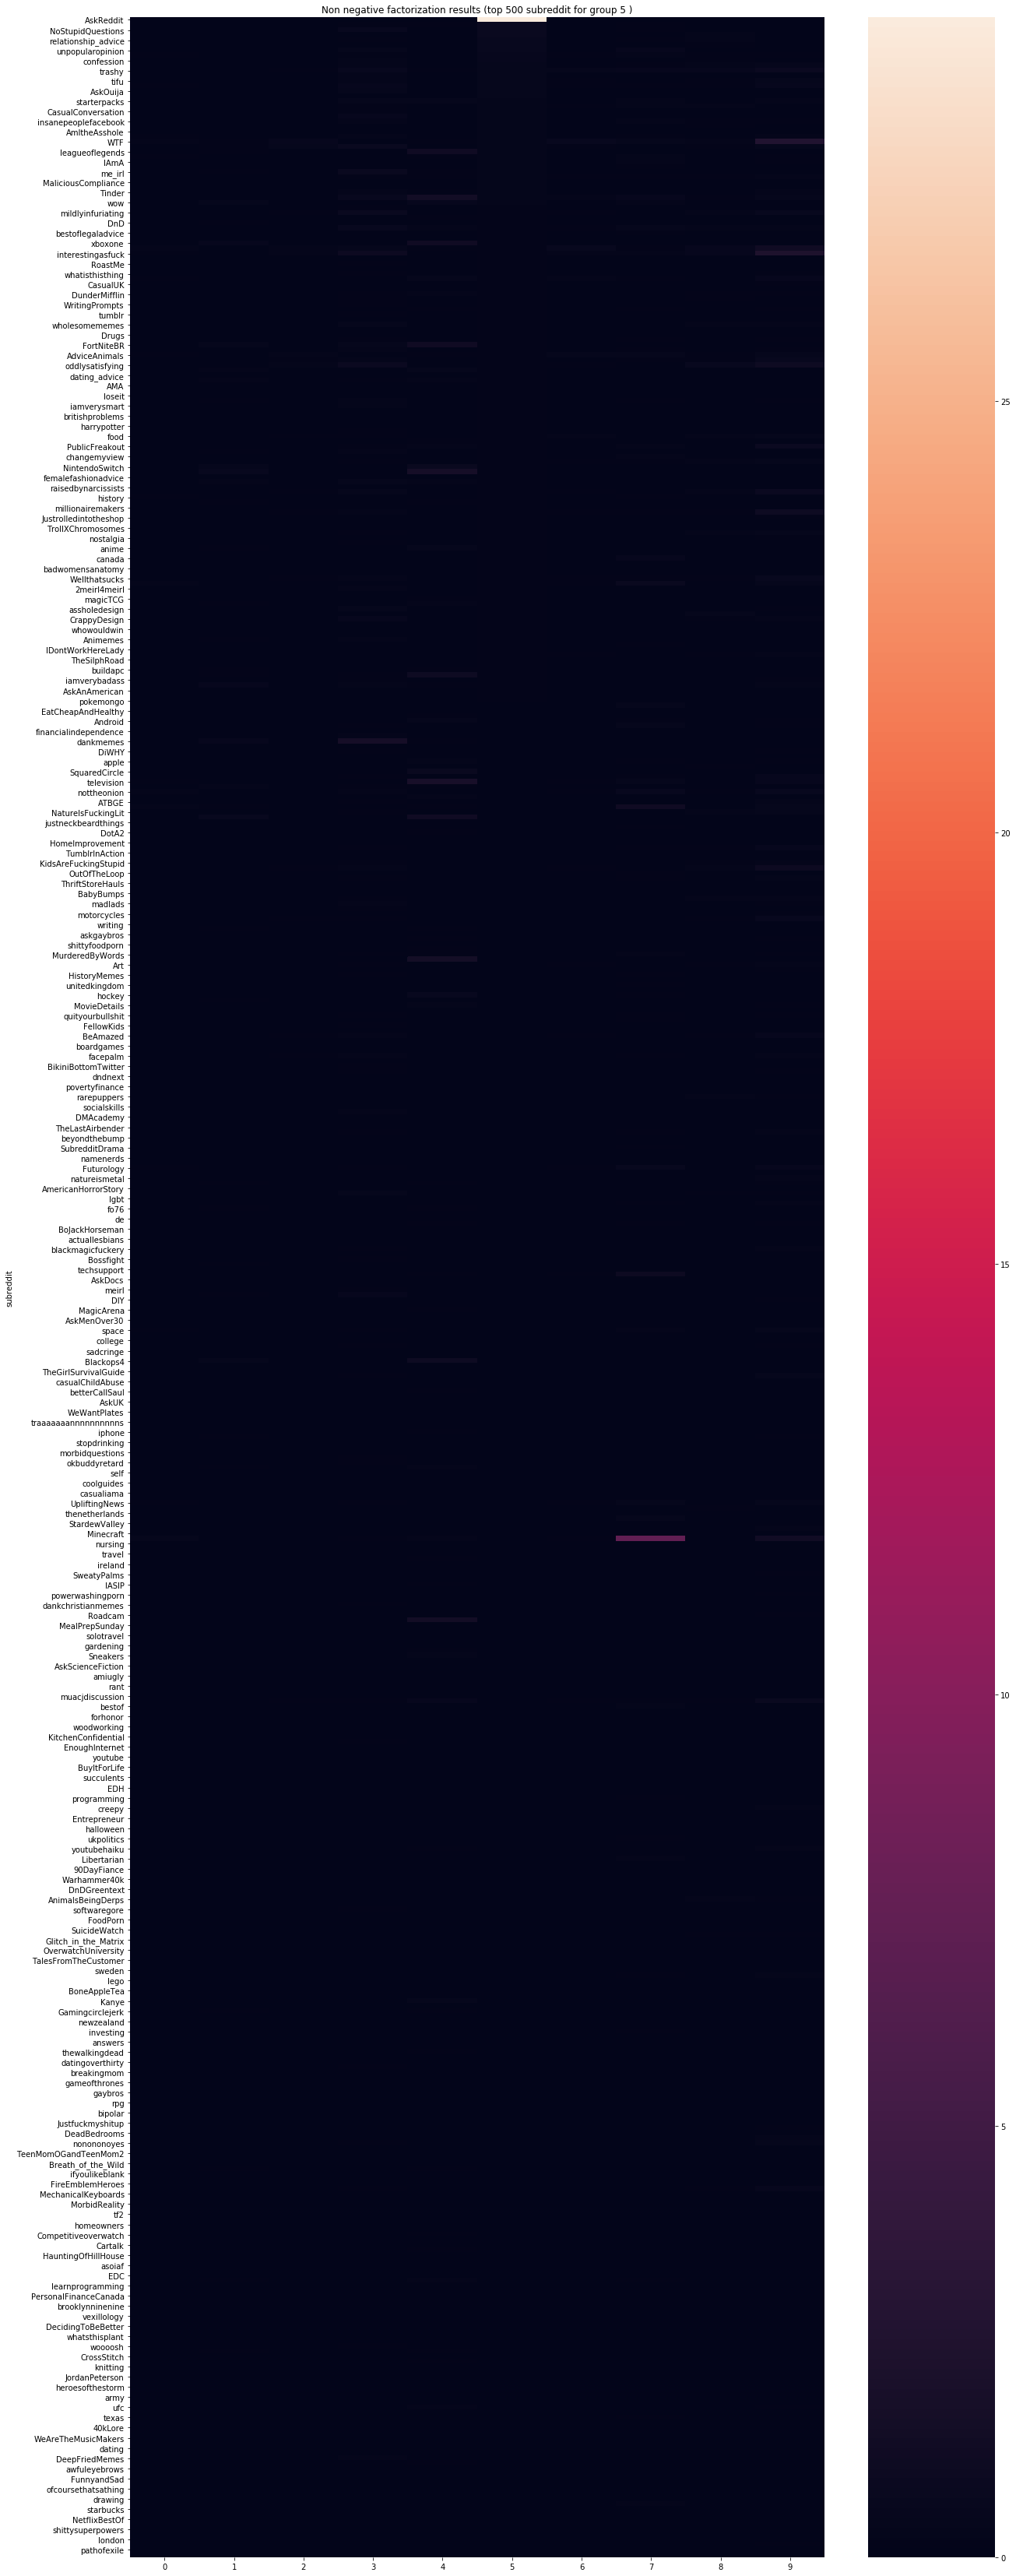

In [180]:
plt.figure(figsize=(20, 60))
ax = plt.axes()
sns.heatmap(df_h[list(range(0,10))].nlargest(500,columns=5),  ax = ax)
ax.set_title("Non negative factorization results (top 500 subreddit for group 5 )")
plt.show();

### Gifs subreddit has the biggest value for the subreddit, and its close to the mildlyinteresting subreddit as well. Subreddits with a large value in this coordinate are oriented to show mostly pictures and gifs to users, altough some serious subreddits have also a large value in this group

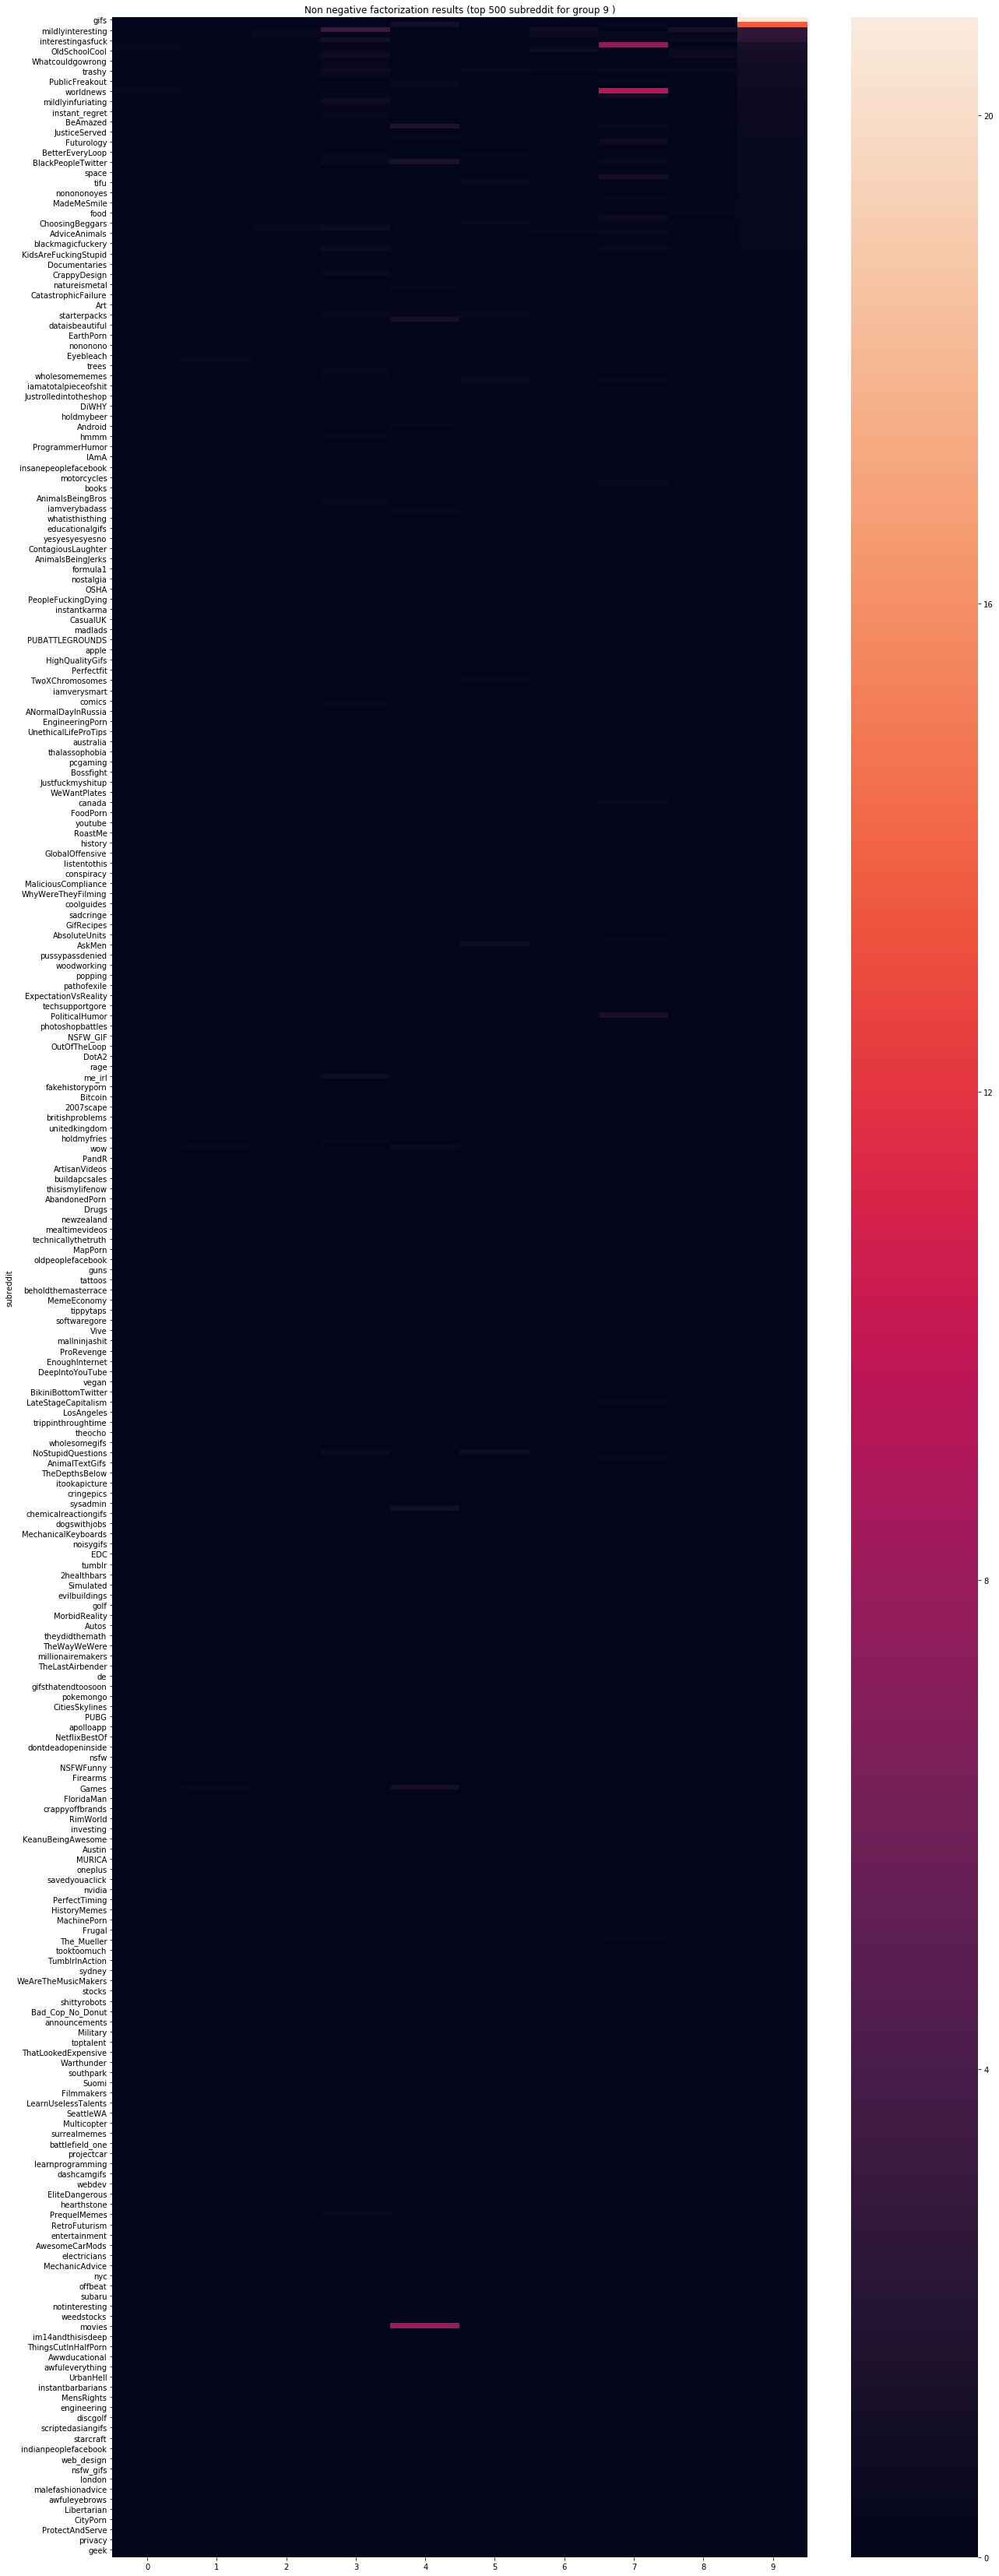

In [223]:
plt.figure(figsize=(20, 60))
ax = plt.axes()
sns.heatmap(df_h[list(range(0,10))].nlargest(500,columns=9),  ax = ax)
ax.set_title("Non negative factorization results (top 500 subreddit for group 9 )")
plt.show();

In [242]:
#Final Table
df_results=pd.DataFrame()

In [243]:
for i in range(0,10):
    df_results[i]=df_h.sort_values(by=i, ascending=False).head(15).index

### This is my interpretation of the resulting groups of subreddits
0. News , technology, science 
1. Gaming platforms and console/pc games
2. Humor oriented subreddits
3. Humor oriented subreddits but oriented to memes and more youth humor
4. Movies , sports and also consoles
5. Conversational oriented subreddits, advice and tips
6. Too general to give an opinion
7. Politics, news
8. Animals, cats, feel-good subreddits
9. Too general to give an opinion


In [244]:
df_results

,0,1,2,3,4,5,6,7,8,9
0,todayilearned,gaming,funny,Showerthoughts,movies,AskReddit,pics,politics,aww,gifs
1,worldnews,PS4,WTF,mildlyinteresting,nfl,AskMen,mildlyinteresting,worldnews,mildlyinteresting,videos
2,news,reddeadredemption,memes,dankmemes,nba,NoStupidQuestions,OldSchoolCool,news,oddlysatisfying,mildlyinteresting
3,WTF,pcmasterrace,mildlyinteresting,memes,fantasyfootball,relationships,WTF,PoliticalHumor,trashy,WTF
4,technology,dankmemes,Jokes,interestingasfuck,television,relationship_advice,trashy,technology,OldSchoolCool,interestingasfuck
5,nottheonion,xboxone,oddlysatisfying,oddlysatisfying,PS4,AskWomen,AdviceAnimals,The_Donald,interestingasfuck,news
6,OldSchoolCool,memes,interestingasfuck,me_irl,baseball,unpopularopinion,interestingasfuck,science,cats,OldSchoolCool
7,science,NintendoSwitch,AdviceAnimals,mildlyinfuriating,CFB,personalfinance,food,nottheonion,food,oddlysatisfying
8,LifeProTips,Blackops4,OldSchoolCool,Jokes,soccer,confession,BlackPeopleTwitter,Futurology,relationship_advice,Whatcouldgowrong
9,interestingasfuck,wow,Whatcouldgowrong,WhitePeopleTwitter,BlackPeopleTwitter,ChoosingBeggars,Music,trashy,rarepuppers,Unexpected


In [251]:
label_group=df_h.idxmax(axis=1)

In [325]:
df_h['label_group']=label_group

In [326]:
df_h_top=df_h.loc[main_subreddits]

In [461]:
from sklearn.manifold import TSNE

In [478]:
tsne = TSNE(n_components=2, 
                         random_state=0, perplexity=10)

In [479]:
Y = tsne.fit_transform(df_h_top[list(range(0,10))])

In [480]:
df_tnse=pd.DataFrame(Y, index=df_h_top.index, columns=['x','y'])

In [481]:
df_tnse=df_tnse.join(df_h_top['label_group'])

In [482]:
size=np.log10(df_interactions.subreddit.value_counts())

In [483]:
df_tnse=df_tnse.join(size)

In [484]:
df_tnse.rename(columns={'subreddit':'size'},inplace=True)

In [485]:
df_tnse

,x,y,label_group,size
AskReddit,-87.739502,118.375427,5,5.845580
politics,46.266315,-8.576367,7,5.326494
funny,24.433929,-36.121201,2,5.181243
leagueoflegends,-16.417702,-46.932980,4,5.028014
gaming,-12.903432,-37.527874,1,5.006667
worldnews,46.152130,-9.305249,7,5.005271
pics,35.971592,-40.310581,6,5.004691
The_Donald,39.713860,-10.297010,7,4.917511
news,46.044605,-9.798164,7,4.913098
nfl,-11.959436,-54.253696,4,4.899645


In [486]:
palette = d3['Category10'][len(np.unique(df_tnse.label_group))]

In [487]:
colors = [palette[x] for x in df_tnse.label_group]

In [488]:
source = ColumnDataSource(
        data=dict(
            x=df_tnse['x'],
            y=df_tnse['y'],
            desc=df_tnse.index,
            label=df_tnse_top.label_group,
            colors=colors,
            size=df_tnse['size']*5
        )
    )

In [489]:
hover = HoverTool(
        tooltips=[
            ("(x,y)", "($x, $y)"),
             ("group", "@label"),
            ("desc", "@desc"),
        ]
    )

In [490]:
p = figure(plot_width=1000, plot_height=1000, tools=[hover], title="TNSE projection of subreddits (top 500)")

In [491]:
p.scatter('x', 'y', size='size', source=source, fill_color='colors')

GlyphRenderer(id='3306', ...)

### Finally, a TNSE projection of the latent non-negative space is visualized for the top 500 communities 
Hover over the points to see the which subreddits are. 
ASkreddit stands out at its own

In [492]:
show(p)